In [ ]:
!pip install wandb
!pip install torcheval
!pip install optuna
!pip install torcheval
!pip install torchmetrics

In [ ]:
import torch
from torch.nn import Module, Sequential, Conv3d, ReLU, MaxPool3d, Linear, LeakyReLU, Flatten, Dropout, CrossEntropyLoss, BatchNorm3d, Softmax
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import ToTensor
from torch.nn.functional import one_hot
from torchvision.transforms import Compose, ToTensor, RandomAffine, RandomHorizontalFlip, RandomVerticalFlip
from torcheval.metrics import MulticlassConfusionMatrix, MulticlassAccuracy, MulticlassF1Score
from torchvision.transforms.functional import hflip, vflip
from torchmetrics.classification import AveragePrecision

from scipy.ndimage import shift,rotate

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import csv

from tqdm import tqdm
import wandb
import h5py
from google.colab import drive
import optuna

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cpu


In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Set random seed for reproducible results
torch.manual_seed(0)

# Dataset and DataLoader

In [ ]:
class ThreeD_Dataset(Dataset):

    def __init__(self, hdf5_path, dataset_type, num_categories, get_orientations=False, use_poseplan=False, transform=None):
        self.X = h5py.File(dataset_path, 'r')['X_' + dataset_type]
        self.y = h5py.File(dataset_path, 'r')['Y_' + dataset_type]
        if use_poseplan:
            self.rot = h5py.File(dataset_path, 'r')['rot_' + dataset_type + '_pp']
        else:
            self.rot = h5py.File(dataset_path, 'r')['rot_' + dataset_type]
        self.num_categories = num_categories
        self.transform = transform
        self.get_orientations = get_orientations
        self.use_poseplan = use_poseplan

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        X = torch.tensor(self.X[idx])
        if self.transform:
            X = self.transform(X)

        y = self.y[idx][0]
        y = one_hot(torch.tensor(y).long(), self.num_categories)

        if self.get_orientations:
            rot = one_hot(torch.tensor(self.rot[idx][0]).long(), 12)
            return X, y, rot
        else:
            return X, y

In [ ]:
volume = 32
batch_size = 32
num_categories = 40

if num_categories==10:
    modelnet_classes = ['bathtub','bed','chair','desk','dresser','monitor','night_stand','sofa','table','toilet']
    poseplan = np.array([3,12,12,12,3,6,3,12,3,12])

    dataset_path = '/content/drive/My Drive/Dataset/ModelNet10_dataset.h5'


else:
    modelnet_classes = ['airplane', 'bathtub', 'bed', 'bench', 'bookshelf', 'bottle', 'bowl', 'car', 'chair', 'cone', 'cup', 'curtain', 'desk', 'door', 'dresser', 'flower_pot', 'glass_box', 'guitar', 'keyboard', 'lamp', 'laptop', 'mantel', 'monitor', 'night_stand', 'person', 'piano', 'plant', 'radio', 'range_hood', 'sink', 'sofa', 'stairs', 'stool', 'table', 'tent', 'toilet', 'tv_stand', 'vase', 'wardrobe', 'xbox']
    poseplan = np.array([12,3,12,1,12,1,1,12,12,1,1,6,12,1,3,1,1,12,1,1,12,12,6,3,1,12,1,1,3,1,12,1,1,3,6,12,6,1,6,6])

    dataset_path = '/content/drive/My Drive/Dataset/ModelNet40_ma_dataset.h5'

In [ ]:
use_poseplan = True

if use_poseplan:
    num_rotations = poseplan
else:
    num_rotations = np.repeat(12, num_categories)

train_set = ThreeD_Dataset(dataset_path, 'train', num_categories, True, use_poseplan) #, transform=transforms)
val_set = ThreeD_Dataset(dataset_path, 'val', num_categories, True, use_poseplan)
test_set = ThreeD_Dataset(dataset_path, 'test', num_categories, True, use_poseplan)

In [ ]:
train_dataloader = DataLoader(train_set, batch_size=batch_size, shuffle=True, drop_last=True)#, num_workers=os.cpu_count())
val_dataloader = DataLoader(val_set, batch_size=batch_size, shuffle=False, drop_last=True)#, num_workers=os.cpu_count())
test_dataloader = DataLoader(test_set, batch_size=12, shuffle=False, drop_last=False)#, num_workers=os.cpu_count())

# Utility functions

## Metrics

In [ ]:
def metrics(predictions, labels, num_categories, macro=True, each=True, weighted=True, F1=True, categories=modelnet_classes, return_value=False):

    if num_categories==10:
      print("\nCONFUSION MATRIX")
      cm = confusion_matrix(labels, predictions)
      ConfusionMatrixDisplay(cm, display_labels=categories).plot(xticks_rotation=60)
      plt.show()

    print("\nACCURACY")
    accuracy_micro = MulticlassAccuracy(average='micro', num_classes=num_categories) #[default]: Calculate the metrics globally.
    accuracy_micro.update(predictions, labels)
    print("Micro (global) accuracy:", accuracy_micro.compute().item())
    if macro:
        accuracy_macro = MulticlassAccuracy(average='macro', num_classes=num_categories) #Calculate metrics for each class separately, and return their unweighted mean
        accuracy_macro.update(predictions, labels)
        print("Macro accuracy:", accuracy_macro.compute().item())
    if each:
        accuracy_per_categorie = MulticlassAccuracy(average=None, num_classes=num_categories) #Calculate the metric for each class separately, and return the metric for every class. NaN is returned if a class has no sample in target.
        accuracy_per_categorie.update(predictions, labels)
        print("Accuracy for each class")
        for i,j in zip(categories, accuracy_per_categorie.compute().numpy()):
            print("\t",i,": ",j)

    if F1:
        print("\nF1-SCORE")
        F1_score_micro = MulticlassF1Score(average='micro', num_classes=num_categories) #[default]: Calculate the metrics globally
        F1_score_micro.update(predictions, labels)
        print("Micro (global) F1_score:", F1_score_micro.compute().item())
        if macro:
            F1_score_macro = MulticlassF1Score(average='macro', num_classes=num_categories) #Calculate metrics for each class separately, and return their unweighted mean
            F1_score_macro.update(predictions, labels)
            print("Macro F1_score:", F1_score_macro.compute().item())
        if weighted:
            F1_score_weighted = MulticlassF1Score(average='weighted', num_classes=num_categories) #Calculate metrics for each class separately, and return their weighted sum. Weights are defined as the proportion of occurrences of each class in “target”.
            F1_score_weighted.update(predictions, labels)
            print("Weighted F1_score:", F1_score_weighted.compute().item())
        if each:
            F1_score_per_categorie = MulticlassF1Score(average=None, num_classes=num_categories) #Calculate the metric for each class separately, and return the metric for every class
            F1_score_per_categorie.update(predictions, labels)
            print("F1_score for each class:")
            for i,j in zip(categories, F1_score_per_categorie.compute().numpy()):
                print("\t",i,": ",j)

    if return_value:
        return accuracy_micro.compute().item()

## Weights inintialization

In [ ]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        torch.nn.init.kaiming_uniform_(m.weight.data)       # He initialization
        if m.bias is not None:
          m.bias.data.zero_()

    elif classname.find('Linear') != -1:
        torch.nn.init.normal_(m.weight.data, 0.0, 0.01)     # initialized from a zero-mean Gaussian with std=0.01
        if m.bias is not None:
          m.bias.data.zero_()

## Inference time

In [ ]:
def inference_time(model, dataset, gpu_warm_up=10):
#measured in ms

  timings=[]
  model.to(device)

  starter, ender = torch.cuda.Event(enable_timing=True), torch.cuda.Event(enable_timing=True)

  with torch.no_grad():
      #GPU warm-up
      for i in range(gpu_warm_up):
        x = dataset[i][0].reshape(1,1,volume,volume,volume).to(device).float()

        y = model(x)

      for data in dataset:
        x = data[0].reshape(1,1,volume,volume,volume).to(device).float()

        starter.record()
        y = model(x)
        ender.record()

        torch.cuda.synchronize() # WAIT FOR GPU SYNC
        curr_time = starter.elapsed_time(ender)
        timings.append(curr_time)

  mean_time = np.mean(timings)
  std_time = np.std(timings)

  return mean_time, std_time

# Cascade 1: MP

## Network definition

In [ ]:
class MP(Module):

    def __init__(self, num_categories, num_rotations):
        super().__init__()

        # Down Sample to 8x8x8
        self.max_pool = MaxPool3d(kernel_size=4, stride=4)

        # Flatten layer
        self.flatten = Flatten()

        # Fully Connected
        self.fc = Sequential(
            Linear(8*8*8, 256),
            Dropout(0.3),
            LeakyReLU(),

            Linear(256, num_categories + num_rotations.sum()),
            ReLU())


    def forward(self, x):
        x = self.max_pool(x)
        x = self.flatten(x)
        x = self.fc(x)
        return x

## Load trained architecture

In [ ]:
net_state_dict = torch.load('/content/drive/My Drive/Dataset/Saved_parameters/Cascade_FC_MN40_parameters.torch', map_location=torch.device('cpu'))

# Network initialization
cascade_1 = MP(num_categories, num_rotations).to(device)
cascade_1.load_state_dict(net_state_dict)

<All keys matched successfully>

## Train

### Initialization

In [ ]:
# Network initialization
cascade_1 = MP(num_categories, num_rotations)
cascade_1.apply(weights_init)

MP(
  (max_pool): MaxPool3d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc): Sequential(
    (0): Linear(in_features=512, out_features=256, bias=True)
    (1): Dropout(p=0.3, inplace=False)
    (2): LeakyReLU(negative_slope=0.01)
    (3): Linear(in_features=256, out_features=252, bias=True)
    (4): ReLU()
  )
)

In [ ]:
print("Number of parameters: ", sum(p.numel() for p in cascade_1.parameters()))

Number of parameters:  196092


### Training

Set hyperparameters, optimizer and loss function

In [ ]:
learning_rate = 0.001
optimizer_weight_decay=0.001

save_parameters, save_folder = False, '/content/drive/My Drive/Dataset/Saved_parameters/'
epochs=30

optimizer = torch.optim.Adam(cascade_1.parameters(), lr=learning_rate, weight_decay=optimizer_weight_decay)

loss_cat = CrossEntropyLoss()
loss_rot = CrossEntropyLoss()
gamma_loss = 0.5

def loss_total(cat, rot, gamma):
    return (1-gamma)*cat + gamma*rot

Connect to **Weight and Biases** to visualise the training procedure

In [ ]:
wandb.init(project='Cascade - FC - MN40',
           entity='nndl',
           config={
            "model": cascade_1,
            "batch size": batch_size,
            "epochs": epochs,
            "learning rate": learning_rate,
            "weight decay": optimizer_weight_decay,
            "optimizer": 'Adam'
            })
wandb.watch(cascade_1, log="all")

accuracy,▁▃▃▄▅▅▆▆▆▇▇▇▇▇▇▇▇▇████████████
accuracy_rot,▁▁▂▃▄▅▅▆▆▆▇▇▇▇▇▇▇▇▇███████████
epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
train_loss,█▇▆▅▄▄▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
train_loss_cat,█▆▅▄▄▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss_rot,█▇▆▅▅▄▄▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▇▆▅▄▄▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
val_loss_cat,█▆▅▅▄▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss_rot,█▇▆▅▅▄▄▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
accuracy,0.64118
accuracy_rot,0.56157


[]

Train

In [ ]:
cascade_1.to(device)
best_val = np.inf
for epoch in range(epochs):
    print(f"Epoch: {epoch+1}")
    cascade_1.train()
    train_loss, train_loss_cat, train_loss_rot = [], [], []

    iterator = tqdm(train_dataloader)
    for batch_x, batch_y, batch_rot in iterator:
        batch_x = batch_x.reshape(batch_size,1,volume,volume,volume).to(device).float()
        batch_y = batch_y.to(device).float()
        batch_rot = batch_rot.to(device).float()

        y_pred = cascade_1(batch_x)
        y_pred_cat = y_pred[:,:num_categories]

        lossc = loss_cat(y_pred_cat, batch_y)

        class_ = batch_y.softmax(axis=1).detach().cpu().numpy().argmax(axis=1)

        y_pred_rot = y_pred[:,num_categories:]
        batch_rot_eff = torch.zeros((batch_size,num_rotations.sum())).to(device)
        for i in range(batch_size):
            batch_rot_eff[i, sum(num_rotations[:class_[i]]) : sum(num_rotations[:class_[i]]) + num_rotations[class_[i]]] = batch_rot[i,:num_rotations[class_[i]]]
        batch_rot = batch_rot_eff

        lossr = loss_rot(y_pred_rot, batch_rot)
        loss = loss_total(lossc, lossr, gamma_loss)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        #scheduler.step()

        # Save train loss for this batch
        train_loss.append(loss.detach().cpu().numpy())
        train_loss_cat.append(lossc.detach().cpu().numpy())
        train_loss_rot.append(lossr.detach().cpu().numpy())

        del batch_x, batch_y, batch_rot, y_pred, y_pred_cat, lossc, class_, y_pred_rot, lossr, loss

    # Average train loss
    train_loss, train_loss_cat, train_loss_rot = np.mean(train_loss), np.mean(train_loss_cat), np.mean(train_loss_rot)
    print(f"Train loss: {train_loss}")
    #print(f"category: {train_loss_cat}")
    #print(f"alignment: {train_loss_rot}")

    cascade_1.eval()
    with torch.no_grad():
        predictions_cat, predictions_rot, labels_cat, labels_rot = [], [], [], []
        for batch_x, batch_y, batch_rot in tqdm(val_dataloader):
            data_shape = batch_x.shape
            batch_x = batch_x.reshape(data_shape[0],1,volume,volume,volume).to(device).float()
            batch_y = batch_y.to(device).float()
            batch_rot = batch_rot.to(device).float()

            y_pred = cascade_1(batch_x)

            y_pred_cat = y_pred[:,:num_categories]
            predictions_cat.append(y_pred_cat)
            class_ = batch_y.softmax(axis=1).detach().cpu().numpy().argmax(axis=1)

            y_pred_rot = y_pred[:,num_categories:]
            batch_rot_eff = torch.zeros((batch_size,num_rotations.sum())).to(device)
            for i in range(batch_size):
                batch_rot_eff[i, sum(num_rotations[:class_[i]]) : sum(num_rotations[:class_[i]]) + num_rotations[class_[i]]] = batch_rot[i,:num_rotations[class_[i]]]
            batch_rot = batch_rot_eff

            predictions_rot.append(y_pred_rot)
            labels_cat.append(batch_y)
            labels_rot.append(batch_rot)

            del batch_x, batch_y, batch_rot, y_pred, y_pred_cat, class_, y_pred_rot

        predictions_cat = torch.cat(predictions_cat, axis=0)
        predictions_rot = torch.cat(predictions_rot, axis=0)
        labels_cat = torch.cat(labels_cat, axis=0)
        labels_rot = torch.cat(labels_rot, axis=0)

        # Evaluate validation loss and accuracy
        val_loss_cat = loss_cat(predictions_cat, labels_cat)
        val_loss_rot = loss_rot(predictions_rot, labels_rot)
        val_loss = loss_total(val_loss_cat, val_loss_rot, gamma_loss)

        val_loss = val_loss.detach().cpu().numpy()
        val_acc_cat = accuracy_score(labels_cat.detach().cpu().numpy().argmax(axis=1), predictions_cat.softmax(axis=1).detach().cpu().numpy().argmax(axis=1))
        val_acc_rot = accuracy_score(labels_rot.detach().cpu().numpy().argmax(axis=1), predictions_rot.softmax(axis=1).detach().cpu().numpy().argmax(axis=1))
        print(f"Validation loss: {val_loss}, accuracy: {val_acc_cat}, accuracy rot: {val_acc_rot}")
        #print(f"category loss: {val_loss_cat}")
        #print(f"alignment loss: {val_loss_rot}")


    wandb.log({'epoch': epoch+1, 'train_loss': train_loss, 'train_loss_cat': train_loss_cat, 'train_loss_rot': train_loss_rot,
              'val_loss': val_loss, 'val_loss_cat': val_loss_cat, 'val_loss_rot': val_loss_rot, 'accuracy': val_acc_cat, 'accuracy_rot': val_acc_rot})


    if val_loss < best_val and save_parameters:
        best_val = val_loss

        # Save network parameters
        torch.save(cascade_1.state_dict(), save_folder+"Cascade_FC_MN40_parameters.torch")
        # Save the optimizer state
        torch.save(optimizer.state_dict(), save_folder+"Cascade_FC_MN40_optimizer_state.torch")
        # Save the scheduler state
        #torch.save(scheduler.state_dict(), save_folder+"scheduler_state.torch")

Epoch: 1


100%|██████████████████████████████████████████████████████████████████████████████| 2953/2953 [00:33<00:00, 88.22it/s]


Train loss: 3.8122265338897705


100%|███████████████████████████████████████████████████████████████████████████████| 738/738 [00:06<00:00, 115.86it/s]


Validation loss: 3.2394847869873047, accuracy: 0.36496443089430897, accuracy rot: 0.2940379403794038
Epoch: 2


100%|██████████████████████████████████████████████████████████████████████████████| 2953/2953 [00:33<00:00, 87.84it/s]


Train loss: 2.834778070449829


100%|███████████████████████████████████████████████████████████████████████████████| 738/738 [00:06<00:00, 115.33it/s]


Validation loss: 2.5134506225585938, accuracy: 0.5465362466124661, accuracy rot: 0.4206470189701897
Epoch: 3


100%|██████████████████████████████████████████████████████████████████████████████| 2953/2953 [00:33<00:00, 88.79it/s]


Train loss: 2.270026445388794


100%|███████████████████████████████████████████████████████████████████████████████| 738/738 [00:06<00:00, 115.51it/s]


Validation loss: 2.037522554397583, accuracy: 0.5935806233062331, accuracy rot: 0.4991531165311653
Epoch: 4


100%|██████████████████████████████████████████████████████████████████████████████| 2953/2953 [00:32<00:00, 90.67it/s]


Train loss: 1.8766847848892212


100%|███████████████████████████████████████████████████████████████████████████████| 738/738 [00:06<00:00, 120.05it/s]


Validation loss: 1.6483421325683594, accuracy: 0.6344850948509485, accuracy rot: 0.5540735094850948
Epoch: 5


100%|██████████████████████████████████████████████████████████████████████████████| 2953/2953 [00:34<00:00, 86.38it/s]


Train loss: 1.6175583600997925


100%|███████████████████████████████████████████████████████████████████████████████| 738/738 [00:06<00:00, 114.32it/s]


Validation loss: 1.4738068580627441, accuracy: 0.6496019647696477, accuracy rot: 0.5935382791327913
Epoch: 6


100%|██████████████████████████████████████████████████████████████████████████████| 2953/2953 [00:33<00:00, 88.42it/s]


Train loss: 1.4410269260406494


100%|███████████████████████████████████████████████████████████████████████████████| 738/738 [00:06<00:00, 117.97it/s]


Validation loss: 1.350954532623291, accuracy: 0.6717056233062331, accuracy rot: 0.5928607723577236
Epoch: 7


100%|██████████████████████████████████████████████████████████████████████████████| 2953/2953 [00:32<00:00, 90.10it/s]


Train loss: 1.3590495586395264


100%|███████████████████████████████████████████████████████████████████████████████| 738/738 [00:06<00:00, 119.66it/s]


Validation loss: 1.3149380683898926, accuracy: 0.666454945799458, accuracy rot: 0.5971375338753387
Epoch: 8


100%|██████████████████████████████████████████████████████████████████████████████| 2953/2953 [00:33<00:00, 89.24it/s]


Train loss: 1.3333674669265747


100%|███████████████████████████████████████████████████████████████████████████████| 738/738 [00:06<00:00, 115.96it/s]


Validation loss: 1.2932896614074707, accuracy: 0.6711128048780488, accuracy rot: 0.6012025745257452
Epoch: 9


100%|██████████████████████████████████████████████████████████████████████████████| 2953/2953 [00:32<00:00, 89.80it/s]


Train loss: 1.3155356645584106


100%|███████████████████████████████████████████████████████████████████████████████| 738/738 [00:06<00:00, 117.26it/s]


Validation loss: 1.281732201576233, accuracy: 0.6753048780487805, accuracy rot: 0.6011602303523035
Epoch: 10


100%|██████████████████████████████████████████████████████████████████████████████| 2953/2953 [00:32<00:00, 91.06it/s]


Train loss: 1.3071303367614746


100%|███████████████████████████████████████████████████████████████████████████████| 738/738 [00:06<00:00, 113.32it/s]


Validation loss: 1.2554069757461548, accuracy: 0.6775914634146342, accuracy rot: 0.6049288617886179
Epoch: 11


100%|██████████████████████████████████████████████████████████████████████████████| 2953/2953 [00:32<00:00, 89.49it/s]


Train loss: 1.3016835451126099


100%|███████████████████████████████████████████████████████████████████████████████| 738/738 [00:06<00:00, 117.50it/s]


Validation loss: 1.2633697986602783, accuracy: 0.6732300135501355, accuracy rot: 0.6123814363143631
Epoch: 12


100%|██████████████████████████████████████████████████████████████████████████████| 2953/2953 [00:33<00:00, 88.48it/s]


Train loss: 1.297690510749817


100%|███████████████████████████████████████████████████████████████████████████████| 738/738 [00:06<00:00, 112.63it/s]


Validation loss: 1.2526934146881104, accuracy: 0.6855521680216802, accuracy rot: 0.6151338075880759
Epoch: 13


100%|██████████████████████████████████████████████████████████████████████████████| 2953/2953 [00:33<00:00, 88.69it/s]


Train loss: 1.295438528060913


100%|███████████████████████████████████████████████████████████████████████████████| 738/738 [00:06<00:00, 118.17it/s]


Validation loss: 1.2629647254943848, accuracy: 0.6794122628726287, accuracy rot: 0.6069613821138211
Epoch: 14


100%|██████████████████████████████████████████████████████████████████████████████| 2953/2953 [00:33<00:00, 88.22it/s]


Train loss: 1.2907963991165161


100%|███████████████████████████████████████████████████████████████████████████████| 738/738 [00:06<00:00, 116.80it/s]


Validation loss: 1.265905737876892, accuracy: 0.6805978997289973, accuracy rot: 0.6117039295392954
Epoch: 15


100%|██████████████████████████████████████████████████████████████████████████████| 2953/2953 [00:33<00:00, 87.55it/s]


Train loss: 1.288588047027588


100%|███████████████████████████████████████████████████████████████████████████████| 738/738 [00:06<00:00, 115.97it/s]


Validation loss: 1.2421265840530396, accuracy: 0.6817835365853658, accuracy rot: 0.6148373983739838
Epoch: 16


100%|██████████████████████████████████████████████████████████████████████████████| 2953/2953 [00:33<00:00, 87.70it/s]


Train loss: 1.2887494564056396


100%|███████████████████████████████████████████████████████████████████████████████| 738/738 [00:06<00:00, 112.99it/s]


Validation loss: 1.2542448043823242, accuracy: 0.6779725609756098, accuracy rot: 0.6144986449864499
Epoch: 17


100%|██████████████████████████████████████████████████████████████████████████████| 2953/2953 [00:34<00:00, 86.07it/s]


Train loss: 1.2879688739776611


100%|███████████████████████████████████████████████████████████████████████████████| 738/738 [00:06<00:00, 116.66it/s]


Validation loss: 1.2440507411956787, accuracy: 0.6883468834688347, accuracy rot: 0.6144563008130082
Epoch: 18


100%|██████████████████████████████████████████████████████████████████████████████| 2953/2953 [00:34<00:00, 86.58it/s]


Train loss: 1.282019019126892


100%|███████████████████████████████████████████████████████████████████████████████| 738/738 [00:06<00:00, 110.53it/s]


Validation loss: 1.245112657546997, accuracy: 0.6916497289972899, accuracy rot: 0.6169122628726287
Epoch: 19


100%|██████████████████████████████████████████████████████████████████████████████| 2953/2953 [00:33<00:00, 87.55it/s]


Train loss: 1.282186508178711


100%|███████████████████████████████████████████████████████████████████████████████| 738/738 [00:06<00:00, 116.63it/s]


Validation loss: 1.253605842590332, accuracy: 0.6828421409214093, accuracy rot: 0.6089092140921409
Epoch: 20


100%|██████████████████████████████████████████████████████████████████████████████| 2953/2953 [00:33<00:00, 88.78it/s]


Train loss: 1.2784218788146973


100%|███████████████████████████████████████████████████████████████████████████████| 738/738 [00:06<00:00, 117.59it/s]


Validation loss: 1.2375915050506592, accuracy: 0.6839430894308943, accuracy rot: 0.6152608401084011
Epoch: 21


100%|██████████████████████████████████████████████████████████████████████████████| 2953/2953 [00:33<00:00, 88.20it/s]


Train loss: 1.2789965867996216


100%|███████████████████████████████████████████████████████████████████████████████| 738/738 [00:06<00:00, 116.19it/s]


Validation loss: 1.2483710050582886, accuracy: 0.6863567073170732, accuracy rot: 0.6120426829268293
Epoch: 22


100%|██████████████████████████████████████████████████████████████████████████████| 2953/2953 [00:33<00:00, 87.66it/s]


Train loss: 1.276766300201416


100%|███████████████████████████████████████████████████████████████████████████████| 738/738 [00:06<00:00, 116.81it/s]


Validation loss: 1.23653244972229, accuracy: 0.694190379403794, accuracy rot: 0.6225016937669376
Epoch: 23


100%|██████████████████████████████████████████████████████████████████████████████| 2953/2953 [00:33<00:00, 88.46it/s]


Train loss: 1.2759861946105957


100%|███████████████████████████████████████████████████████████████████████████████| 738/738 [00:06<00:00, 116.17it/s]


Validation loss: 1.2351148128509521, accuracy: 0.6951219512195121, accuracy rot: 0.6185213414634146
Epoch: 24


100%|██████████████████████████████████████████████████████████████████████████████| 2953/2953 [00:33<00:00, 88.68it/s]


Train loss: 1.273024082183838


100%|███████████████████████████████████████████████████████████████████████████████| 738/738 [00:06<00:00, 117.58it/s]


Validation loss: 1.2270647287368774, accuracy: 0.6928353658536586, accuracy rot: 0.6201727642276422
Epoch: 25


100%|██████████████████████████████████████████████████████████████████████████████| 2953/2953 [00:33<00:00, 89.20it/s]


Train loss: 1.2717604637145996


100%|███████████████████████████████████████████████████████████████████████████████| 738/738 [00:06<00:00, 115.15it/s]


Validation loss: 1.230356216430664, accuracy: 0.693724593495935, accuracy rot: 0.6183943089430894
Epoch: 26


100%|██████████████████████████████████████████████████████████████████████████████| 2953/2953 [00:32<00:00, 90.39it/s]


Train loss: 1.2705978155136108


100%|███████████████████████████████████████████████████████████████████████████████| 738/738 [00:06<00:00, 119.68it/s]


Validation loss: 1.247053623199463, accuracy: 0.6855098238482384, accuracy rot: 0.6059451219512195
Epoch: 27


100%|██████████████████████████████████████████████████████████████████████████████| 2953/2953 [00:33<00:00, 87.98it/s]


Train loss: 1.272304654121399


100%|███████████████████████████████████████████████████████████████████████████████| 738/738 [00:06<00:00, 113.56it/s]


Validation loss: 1.2300474643707275, accuracy: 0.6915226964769647, accuracy rot: 0.6197916666666666
Epoch: 28


100%|██████████████████████████████████████████████████████████████████████████████| 2953/2953 [00:32<00:00, 90.28it/s]


Train loss: 1.2695509195327759


100%|███████████████████████████████████████████████████████████████████████████████| 738/738 [00:06<00:00, 116.84it/s]


Validation loss: 1.2364729642868042, accuracy: 0.6923272357723578, accuracy rot: 0.621019647696477
Epoch: 29


100%|██████████████████████████████████████████████████████████████████████████████| 2953/2953 [00:32<00:00, 89.71it/s]


Train loss: 1.2712481021881104


100%|███████████████████████████████████████████████████████████████████████████████| 738/738 [00:06<00:00, 113.29it/s]


Validation loss: 1.2390282154083252, accuracy: 0.6870765582655827, accuracy rot: 0.6156842818428184
Epoch: 30


100%|██████████████████████████████████████████████████████████████████████████████| 2953/2953 [00:34<00:00, 86.11it/s]


Train loss: 1.2682632207870483


100%|███████████████████████████████████████████████████████████████████████████████| 738/738 [00:06<00:00, 114.41it/s]

Validation loss: 1.2398154735565186, accuracy: 0.6932588075880759, accuracy rot: 0.6134400406504065


### Metrics on validation set

In [ ]:
cascade_1.eval()
cascade_1.to(device)
with torch.no_grad():
    predictions, labels, predictions_rot, labels_rot = [], [], [], []
    for batch_x, batch_y, batch_rot in tqdm(val_dataloader):
        data_shape = batch_x.shape
        batch_x = batch_x.reshape(data_shape[0],1,volume,volume,volume).to(device).float()
        batch_y = batch_y.to(device).float()
        batch_rot = batch_rot.to(device).float()

        y_pred = cascade_1(batch_x)
        y_pred_cat = y_pred[:,:num_categories]

        predictions.append(y_pred_cat)
        labels.append(batch_y)

        class_ = batch_y.softmax(axis=1).detach().cpu().numpy().argmax(axis=1)

        y_pred_rot = y_pred[:,num_categories:]
        batch_rot_eff = torch.zeros((data_shape[0],num_rotations.sum())).to(device)
        for i in range(data_shape[0]):
            batch_rot_eff[i, sum(num_rotations[:class_[i]]) : sum(num_rotations[:class_[i]]) + num_rotations[class_[i]]] = batch_rot[i,:num_rotations[class_[i]]]
        batch_rot = batch_rot_eff

        predictions_rot.append(y_pred_rot)
        labels_rot.append(batch_rot)

        del batch_x, batch_y, batch_rot, class_, y_pred, y_pred_cat, y_pred_rot

predictions = torch.cat(predictions, axis=0).softmax(axis=1).detach().cpu().argmax(axis=1)
labels = torch.cat(labels, axis=0).detach().cpu().argmax(axis=1)
predictions_rot = torch.cat(predictions_rot, axis=0).softmax(axis=1).detach().cpu().argmax(axis=1)
labels_rot = torch.cat(labels_rot, axis=0).detach().cpu().argmax(axis=1)
print(f'\nAccuracy on object classification = {accuracy_score(labels,predictions)*100:.2f} %')
print(f'Accuracy on view classification = {accuracy_score(labels_rot,predictions_rot)*100:.2f} %')

100%|██████████| 738/738 [00:14<00:00, 51.59it/s]



Accuracy on object classification = 69.28 %
Accuracy on view classification = 62.02 %


In [ ]:
metrics(predictions, labels, num_categories, macro=True, each=True, weighted=False, F1=True)

/usr/local/lib/python3.10/dist-packages/torcheval/metrics/functional/classification/accuracy.py:275: UserWarning: The reduce argument of torch.scatter with Tensor src is deprecated and will be removed in a future PyTorch release. Use torch.scatter_reduce instead for more reduction options. (Triggered internally at ../aten/src/ATen/native/TensorAdvancedIndexing.cpp:224.)
  num_correct = mask.new_zeros(num_classes).scatter_(0, target, mask, reduce="add")



ACCURACY
Micro (global) accuracy: 0.6928353905677795
Macro accuracy: 0.5685995817184448
Accuracy for each class
	 airplane :  0.94521606
	 bathtub :  0.48666668
	 bed :  0.88276833
	 bench :  0.5135659
	 bookshelf :  0.72470236
	 bottle :  0.8459596
	 bowl :  0.61538464
	 car :  0.8402778
	 chair :  0.9698465
	 cone :  0.5810185
	 cup :  0.3425926
	 curtain :  0.38271606
	 desk :  0.59477127
	 door :  0.23511904
	 dresser :  0.5427928
	 flower_pot :  0.0
	 glass_box :  0.3267544
	 guitar :  0.81565654
	 keyboard :  0.17816092
	 lamp :  0.37931034
	 laptop :  0.9032258
	 mantel :  0.77011496
	 monitor :  0.88949275
	 night_stand :  0.6691176
	 person :  0.6909722
	 piano :  0.43055555
	 plant :  0.6979167
	 radio :  0.19907407
	 range_hood :  0.59821427
	 sink :  0.3125
	 sofa :  0.86339664
	 stairs :  0.6622807
	 stool :  0.55701756
	 table :  0.8113426
	 tent :  0.5253623
	 toilet :  0.8134328
	 tv_stand :  0.42610064
	 vase :  0.7205882
	 wardrobe :  0.0
	 xbox :  0.0

F1-SCORE
Micr

### Metrics on test set

In [ ]:
cascade_1.eval()

with torch.no_grad():
    predictions, predictions_rot, labels, labels_rot = [], [], [], []
    predictions_vot, labels_vot = [], []

    for batch_x, batch_y, batch_rot in tqdm(test_dataloader):

        data_shape = batch_x.shape
        batch_x = batch_x.reshape(data_shape[0],1,volume,volume,volume).to(device).float()
        batch_y = batch_y.to(device).float()
        batch_rot = batch_rot.to(device).float()

        y_pred = cascade_1(batch_x)

        y_pred_cat = y_pred[:,:num_categories]
        predictions.append(y_pred_cat)
        labels.append(batch_y)

        class_ = batch_y.softmax(axis=1).detach().cpu().numpy().argmax(axis=1)

        y_pred_rot = y_pred[:,num_categories:]
        batch_rot_eff = torch.zeros((data_shape[0],num_rotations.sum())).to(device)
        for i in range(data_shape[0]):
            batch_rot_eff[i, sum(num_rotations[:class_[i]]) : sum(num_rotations[:class_[i]]) + num_rotations[class_[i]]] = batch_rot[i,:num_rotations[class_[i]]]
        batch_rot = batch_rot_eff

        predictions_rot.append(y_pred_rot)
        labels_rot.append(batch_rot)

        y_pred_cat = torch.sum(y_pred_cat.softmax(axis=1), 0)
        predictions_vot.append(y_pred_cat.detach().cpu().numpy().argmax())
        labels_vot.append(batch_y[0].detach().cpu().numpy().argmax())

        del batch_x, batch_y, batch_rot, y_pred, y_pred_cat, class_, y_pred_rot

predictions = torch.cat(predictions, axis=0).softmax(axis=1).detach().cpu().argmax(axis=1)
predictions_rot = torch.cat(predictions_rot, axis=0).softmax(axis=1).detach().cpu().argmax(axis=1)
labels = torch.cat(labels, axis=0).detach().cpu().argmax(axis=1)
labels_rot = torch.cat(labels_rot, axis=0).detach().cpu().argmax(axis=1)

print(f'\nAccuracy (vanilla) = {accuracy_score(labels,predictions)*100:.2f} %')
print(f'Accuracy (rotation labels - vanilla) = {accuracy_score(labels_rot,predictions_rot)*100:.2f} %')
print(f'\nAccuracy (voting) = {accuracy_score(labels_vot,predictions_vot)*100:.2f} %')


100%|██████████| 2468/2468 [00:12<00:00, 202.34it/s]



Accuracy (vanilla) = 66.56 %
Accuracy (rotation labels - vanilla) = 59.52 %

Accuracy (voting) = 69.37 %


In [ ]:
metrics(predictions, labels, num_categories, macro=True, each=True, weighted=False, F1=True)


ACCURACY
Micro (global) accuracy: 0.6655523777008057
Macro accuracy: 0.5686162710189819
Accuracy for each class
	 airplane :  0.9941667
	 bathtub :  0.415
	 bed :  0.92333335
	 bench :  0.4625
	 bookshelf :  0.7683333
	 bottle :  0.81583333
	 bowl :  0.8
	 car :  0.8475
	 chair :  0.9433333
	 cone :  0.6
	 cup :  0.4125
	 curtain :  0.24166666
	 desk :  0.45445737
	 door :  0.44583333
	 dresser :  0.5862403
	 flower_pot :  0.0
	 glass_box :  0.4375
	 guitar :  0.9075
	 keyboard :  0.175
	 lamp :  0.32083333
	 laptop :  0.8875
	 mantel :  0.80333334
	 monitor :  0.8358333
	 night_stand :  0.56395346
	 person :  0.84166664
	 piano :  0.50166667
	 plant :  0.50416666
	 radio :  0.108333334
	 range_hood :  0.66333336
	 sink :  0.34166667
	 sofa :  0.8775
	 stairs :  0.6375
	 stool :  0.475
	 table :  0.63166666
	 tent :  0.60833335
	 toilet :  0.9091667
	 tv_stand :  0.35666665
	 vase :  0.6458333
	 wardrobe :  0.0
	 xbox :  0.0

F1-SCORE
Micro (global) F1_score: 0.6655523777008057
Macro 

## Inference time

In [ ]:
mean, std = inference_time(cascade_1, val_set)
print("mean inference time: ", mean)
print("std = ",std)

mean inference time:  0.28657154651449585
std =  0.192264974534996


# Cascade 2: ORION

## Network definition

In [ ]:
class ORION(Module):

    def __init__(self, num_categories, num_rotations, in_channels=1, filter=32):
        super().__init__()

        self.conv = Sequential(
            # Layer 1: 3D conv(filters_num=32, filter_size=5, strides=2)
            # Input: 1@(32*32*32), Output: 32@(14*14*14)
            Conv3d(in_channels, out_channels=filter, kernel_size=5, stride=2),
            BatchNorm3d(filter),
            LeakyReLU(0.1),
            Dropout(0.2),

            # Layer 2: 3D conv(filters_num=32, filte_size=3, strides=1)
            # Input: 32@(14*14*14), Output: 32@(12x12x12)
            Conv3d(in_channels=filter, out_channels=filter, kernel_size=3, stride=1),
            BatchNorm3d(filter),
            LeakyReLU(0.1),

            # Layer 3: Max-pooling (2x2x2)
            # Input: 32@(12x12x12), Output: 32@(6x6x6)
            MaxPool3d(kernel_size=2, stride=2),
            Dropout(0.3) )


        # Flatten layer
        self.flatten = Flatten()

        # Fully Connected
        self.fc = Sequential(
            # Layer 4: Fully Connected 128
            # Input: 1@(6*6*6)*32, Output: 1@128
            Linear(6*6*6*32, 128),
            LeakyReLU(0.1),
            Dropout(0.4),

            # Layer 5: Fully Connected K class each with num_rotations[i] possible alignments
            # Input: 1@128, Output: 1@K+sum(num_rotations)
            Linear(128, num_categories + num_rotations.sum()),
            ReLU() )


    def forward(self, x):
        x = self.conv(x)
        x = self.flatten(x)
        x = self.fc(x)
        return x

## Load trained architecture

In [ ]:
#net_state_dict = torch.load('/content/drive/My Drive/Dataset/Saved_parameters/Orion_MN10_parameters_Sage_feather__epoch51.torch', map_location=torch.device('cpu'))
net_state_dict = torch.load('/content/drive/My Drive/Dataset/Saved_parameters/Orion_MN40_parameters_Electric_snowball__epoch52.torch', map_location=torch.device('cpu'))

# Network initialization
cascade_2 = ORION(num_categories, num_rotations).to(device)
cascade_2.load_state_dict(net_state_dict)

<All keys matched successfully>

# Adaptive thresholding strategy: probability threshold exploration

$\theta^*_C$ is the adaptive threshold for class $C$

\begin{gather*}
    \theta^*_C = argmax_{\theta_C} (N^+_C (\theta_C) ) \\
    \text{such that:} \hspace{1cm} \frac{N^+_C(\theta_C)-N^+_C(\phi^*_C)}{N^+_C(\theta_C)-N^+_C(\phi^*_C) + N^-_C(\theta_C)} \geq q
\end{gather*}
where $N^+_C (\theta_C)$ and $N^-_C (\theta_C)$ refer to the number of positive and negative samples of category C which have been classified with probability greater or equal than $\theta_C$

$\phi^*_C$ refers to a specific threshold obtained in the following manner:
\begin{gather*}
    \phi^*_C = argmax_{\phi_C} (N^+_C (\phi_C) ) \\
    \text{such that:} \hspace{1cm} \frac{N^+_C(\phi_C)}{N^+_C(\phi_C) + N^-_C(\phi_C)} = 1
\end{gather*}
With these definitions, $N^+_C(\phi^*_C)$ refers to the number of correctly classified samples of class $C$, in the case where none of the samples of that class is misclassified.



In [ ]:
#in order to apply voting for the probability threshold exploration the batch_size for the validation data is change to 12
val_dataloader = DataLoader(val_set, batch_size=12, shuffle=False, drop_last=False)

Find  $\phi^*_C$ and $N^+_C(\phi^*_C)$ by looking at the results from MP

In [ ]:
cascade_1.eval()

p, true_false, cat = [], [], []

with torch.no_grad():

     for batch_x, batch_y, _ in tqdm(val_dataloader):
        data_shape = batch_x.shape
        batch_x = batch_x.reshape(data_shape[0],1,volume,volume,volume).to(device).float()
        batch_y = batch_y.to(device).float()

        #Cascade 1: MP
        y_pred = cascade_1(batch_x)
        y_pred_cat = y_pred[:,:num_categories]
        n = y_pred_cat.shape[0]

        y_pred_cat = torch.sum(y_pred_cat.softmax(axis=1), 0).detach().cpu().numpy()

        prob = y_pred_cat / n
        p.append(prob.max())

        y_pred_cat = y_pred_cat.argmax()
        label = batch_y[0].detach().cpu().numpy().argmax()

        cat.append(y_pred_cat)

        if y_pred_cat==label:
          true_false.append(1)
        else:
          true_false.append(0)

        del batch_x, batch_y, y_pred, y_pred_cat

100%|██████████| 1968/1968 [00:09<00:00, 213.35it/s]


In [ ]:
df = pd.DataFrame(
    {'probability': p,
     'classification': true_false,
     'category': cat
     })
df

,probability,classification,category
0,0.925741,1,0
1,0.980818,1,0
2,0.980538,1,0
3,0.979802,1,0
4,0.486917,1,0
...,...,...,...
1963,0.509253,0,4
1964,0.534918,0,4
1965,0.323710,0,25
1966,0.509253,0,4


In [ ]:
phi = np.ones(num_categories)
N_phi = np.zeros(num_categories)

prob_range = (np.arange(0, 1.05, 0.05))
category = np.arange(0,num_categories,1)

for i in category:
  for theta in prob_range:
    df_theta = df[df['probability']>=theta].groupby('category').agg({'category': 'count', 'classification': 'sum'}).rename(columns={'category': 'total', 'classification': 'correct'}).reset_index()

    if df_theta[df_theta['category']==i].empty:
      break

    corr = df_theta.loc[df_theta['category']==i,'correct'].values[0]
    tot = df_theta.loc[df_theta['category']==i,'total'].values[0]

    if corr/tot==1: #p=1
      phi[i] = theta
      N_phi[i] = corr
      break

# print("phi = ", phi)
# print("N_phi = ", N_phi)

Calculate $\theta^*_C$ for different values of $q$

In [ ]:
cascade_1.eval()
cascade_2.eval()

prob_range = (np.arange(0, 1.05, 0.05))
category = np.arange(0,num_categories,1)
treshold_values = np.arange(0.6, 1, 0.05)

acc_cat, acc_cat_cascade1, acc_cat_cascade2, cascade1_numclass, cascade2_numclass = [], [], [], [], []

for q in treshold_values:

  theta_c = np.ones(num_categories)

  #Find Theta_c
  for i in category:
    for theta in prob_range:
      df_theta = df[df['probability']>=theta].groupby('category').agg({'category': 'count', 'classification': 'sum'}).rename(columns={'category': 'total', 'classification': 'correct'}).reset_index()

      if df_theta[df_theta['category']==i].empty:
        continue

      corr = df_theta.loc[df_theta['category']==i,'correct'].values[0]
      tot = df_theta.loc[df_theta['category']==i,'total'].values[0]

      if (tot - N_phi[i]) != 0:
        ratio = (corr - N_phi[i]) / (tot - N_phi[i])
        if ratio >= q:
            theta_c[i] = theta
            break
      elif (corr - N_phi[i]) == 0: #all objects of a category are correctly classified
          theta_c[i] = theta
          break


  with torch.no_grad():
      predictions_vot, labels_vot, predictions_vot_cascade1, labels_vot_cascade1, predictions_vot_cascade2, labels_vot_cascade2 = [], [], [], [], [], []

      for batch_x, batch_y, _ in test_dataloader:
          data_shape = batch_x.shape
          batch_x = batch_x.reshape(data_shape[0],1,volume,volume,volume).to(device).float()
          batch_y = batch_y.to(device).float()


          #Cascade 1: FC-net
          y_pred = cascade_1(batch_x)
          y_pred_cat = y_pred[:,:num_categories]
          n = y_pred_cat.shape[0]
          y_pred_cat = torch.sum(y_pred_cat.softmax(axis=1), 0).detach().cpu().numpy()

          prob = y_pred_cat / n

          y_pred_cat = y_pred_cat.argmax()

          if prob.max() > theta_c[y_pred_cat]:
            predictions_vot_cascade1.append(y_pred_cat)
            labels_vot_cascade1.append(batch_y[0].detach().cpu().numpy().argmax())



          #Cascade 2: ORION
          else:
            y_pred = cascade_2(batch_x)
            y_pred_cat = y_pred[:,:num_categories]
            y_pred_cat = torch.sum(y_pred_cat.softmax(axis=1), 0)

            predictions_vot_cascade2.append(y_pred_cat.detach().cpu().numpy().argmax())
            labels_vot_cascade2.append(batch_y[0].detach().cpu().numpy().argmax())



          del batch_x, batch_y, y_pred, y_pred_cat

  predictions_cat = torch.cat((torch.tensor(predictions_vot_cascade1), torch.tensor(predictions_vot_cascade2)))
  labels_cat = torch.cat((torch.tensor(labels_vot_cascade1), torch.tensor(labels_vot_cascade2)))

  acc_cat_cascade1.append(accuracy_score(labels_vot_cascade1, predictions_vot_cascade1))
  acc_cat_cascade2.append(accuracy_score(labels_vot_cascade2, predictions_vot_cascade2))

  acc_cat.append(accuracy_score(labels_cat,predictions_cat))

  cascade1_numclass.append(len(predictions_vot_cascade1))
  cascade2_numclass.append(len(predictions_vot_cascade2))

  #print("theta_c = ",theta_c)

In [ ]:
t_mp = 0.28
t_orion = 0.73
t = [t_mp + (i/(i+j))*t_orion for i,j in zip(cascade2_numclass, cascade1_numclass)]

df_results = pd.DataFrame(
    {'probability treshold': treshold_values,
     'accuracy category': acc_cat,
     'accuracy category MP': acc_cat_cascade1,
     'accuracy category ORION': acc_cat_cascade2,
     'classified by MP': cascade1_numclass, #number of objects classified by MP
     'classified by ORION': cascade2_numclass, #number of objects classified by ORION,
     'inference time': t
    })
df_results.sort_values('probability treshold')

,probability treshold,accuracy category,accuracy category MP,accuracy category ORION,classified by MP,classified by ORION,inference time
0,0.60,0.745543,0.741764,0.764851,2064,404,0.399498
1,0.65,0.762966,0.761487,0.768362,1937,531,0.437062
2,0.70,0.791734,0.793821,0.787261,1683,785,0.512192
3,0.75,0.808752,0.824841,0.780624,1570,898,0.545616
4,0.80,0.822528,0.847763,0.790203,1386,1082,0.600041
5,0.85,0.837925,0.893530,0.783480,1221,1247,0.648845
6,0.90,0.847650,0.922232,0.788364,1093,1375,0.686706
7,0.95,0.858590,0.959309,0.809294,811,1657,0.770118


## Graphs

In [ ]:
cascade_1.eval()
cascade_2.eval()

prob_range = (np.arange(0, 1.05, 0.05))
category = np.arange(0,num_categories,1)

q=0.8
#treshold_values = np.arange(0.6, 1, 0.05)

cascade1_count = np.zeros(num_categories)
cascade2_count = np.zeros(num_categories)

theta_c = np.ones(num_categories)

#Find Theta_c
for i in category:
  for theta in prob_range:
    df_theta = df[df['probability']>=theta].groupby('category').agg({'category': 'count', 'classification': 'sum'}).rename(columns={'category': 'total', 'classification': 'correct'}).reset_index()

    if df_theta[df_theta['category']==i].empty:
      continue

    corr = df_theta.loc[df_theta['category']==i,'correct'].values[0]
    tot = df_theta.loc[df_theta['category']==i,'total'].values[0]

    if (tot - N_phi[i]) != 0:
      ratio = (corr - N_phi[i]) / (tot - N_phi[i])
      if ratio >= q:
          theta_c[i] = theta
          break
    elif (corr - N_phi[i]) == 0: #all objects of a category are correctly classified
        theta_c[i] = theta
        break


with torch.no_grad():

    for batch_x, batch_y, _ in test_dataloader:
        data_shape = batch_x.shape
        batch_x = batch_x.reshape(data_shape[0],1,volume,volume,volume).to(device).float()
        batch_y = batch_y.to(device).float()

        #Cascade 1: FC-net
        y_pred = cascade_1(batch_x)
        y_pred_cat = y_pred[:,:num_categories]

        n = y_pred_cat.shape[0]
        y_pred_cat = torch.sum(y_pred_cat.softmax(axis=1), 0).detach().cpu().numpy()


        prob = y_pred_cat / n

        y_pred_cat = y_pred_cat.argmax()

        if prob.max() > theta_c[y_pred_cat]:
          cascade1_count[y_pred_cat] = cascade1_count[y_pred_cat]+1


        #Cascade 2: ORION
        else:
          y_pred = cascade_2(batch_x)
          y_pred_cat = y_pred[:,:num_categories]
          y_pred_cat = torch.sum(y_pred_cat.softmax(axis=1), 0).detach().cpu().numpy().argmax()

          cascade2_count[y_pred_cat] = cascade2_count[y_pred_cat]+1

        del batch_x, batch_y, y_pred, y_pred_cat

Plot of the distribution of the number of samples classified by MP and Orion per category for q=0.8

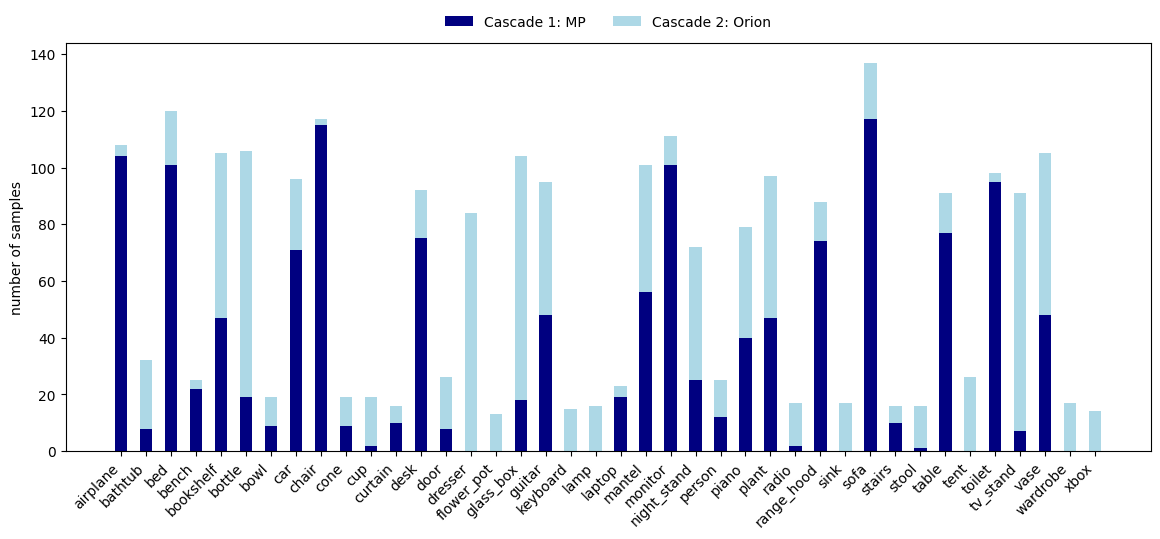

In [ ]:
weight_counts = {
    "Cascade 1: MP": [cascade1_count, 'navy'],
    "Cascade 2: Orion": [cascade2_count, 'lightblue']
}
width = 0.5

if num_categories==10:
  fig, ax = plt.subplots(figsize=(6,4))
elif num_categories==40:
  fig, ax = plt.subplots(figsize=(14,6))

fig.autofmt_xdate(rotation=45)

bottom = np.zeros(num_categories)
for boolean, [weight_count, c] in weight_counts.items():
    p = ax.bar(modelnet_classes, weight_count, width, label=boolean, bottom=bottom, color=c)
    bottom += weight_count

ax.set_ylabel('number of samples')
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.1), ncol=3, frameon=False)
plt.show()

Pass rates for different threshold values

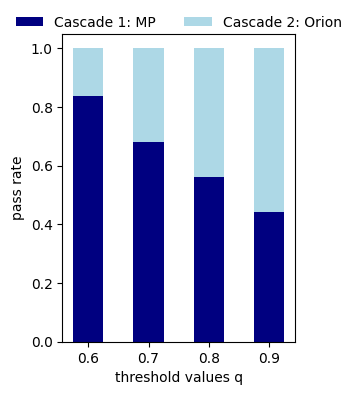

In [ ]:
q_label = ['0.6', '0.7', '0.8', '0.9']

weight_counts = {
    "Cascade 1: MP": [np.array(cascade1_numclass[0::2])/2468, 'navy'],
    "Cascade 2: Orion": [np.array(cascade2_numclass[0::2])/2468, 'lightblue']
}
width = 0.5


fig, ax = plt.subplots(figsize=(3,4))

bottom = np.zeros(len(q_label))
for boolean, [weight_count, c] in weight_counts.items():
    p = ax.bar(q_label, weight_count, width, label=boolean, bottom=bottom, color=c)
    bottom += weight_count

ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.1), ncol=3, frameon=False)
ax.set_ylabel('pass rate')
ax.set_xlabel('threshold values q')

plt.show()

# Precision-recall curves

### Cascade

In [ ]:
q = 0.9
#treshold_values = np.arange(0.6, 1, 0.1)

cascade_1.eval()
cascade_2.eval()

prob_range = (np.arange(0, 1.05, 0.05))
category = np.arange(0,num_categories,1)

theta_c = np.ones(num_categories)

#Find Theta_c
for i in category:
  for theta in prob_range:
    df_theta = df[df['probability']>=theta].groupby('category').agg({'category': 'count', 'classification': 'sum'}).rename(columns={'category': 'total', 'classification': 'correct'}).reset_index()

    if df_theta[df_theta['category']==i].empty:
      continue

    corr = df_theta.loc[df_theta['category']==i,'correct'].values[0]
    tot = df_theta.loc[df_theta['category']==i,'total'].values[0]

    if (tot - N_phi[i]) != 0:
      ratio = (corr - N_phi[i]) / (tot - N_phi[i])
      if ratio >= q:
          theta_c[i] = theta
          break
    elif (corr - N_phi[i]) == 0: #all objects of a category are correctly classified
        theta_c[i] = theta
        break

with torch.no_grad():
    predictions_vot, labels_vot, p, preds = [], [], [], []

    for batch_x, batch_y, _ in test_dataloader:
        data_shape = batch_x.shape
        batch_x = batch_x.reshape(data_shape[0],1,volume,volume,volume).to(device).float()
        batch_y = batch_y.to(device).float()


        #Cascade 1: MP
        y_pred = cascade_1(batch_x)
        y_pred_cat = y_pred[:,:num_categories]

        n = y_pred_cat.shape[0] #12

        y_pred_cat = torch.sum(y_pred_cat.softmax(axis=1), 0).detach().cpu().numpy()

        prob = y_pred_cat / n

        y_pred_cat = y_pred_cat.argmax()

        if prob.max() > theta_c[y_pred_cat]:
          predictions_vot.append(y_pred_cat)
          labels_vot.append(batch_y[0].detach().cpu().numpy().argmax())
          preds.append(prob)
          p.append(prob.max())



        #Cascade 2: ORION
        else:
          y_pred = cascade_2(batch_x)
          y_pred_cat = y_pred[:,:num_categories]
          n = y_pred_cat.shape[0] #12
          y_pred_cat = torch.sum(y_pred_cat.softmax(axis=1), 0).detach().cpu().numpy()
          prob = y_pred_cat / n
          preds.append(prob)
          p.append(prob.max())

          predictions_vot.append(y_pred_cat.argmax())
          labels_vot.append(batch_y[0].detach().cpu().numpy().argmax())


        del batch_x, batch_y, y_pred, y_pred_cat

average_precision = AveragePrecision(task="multiclass", num_classes=num_categories)
print("\nAP = ", average_precision(torch.tensor(np.array(preds)), torch.tensor(np.array(labels_vot))).item())


AP =  0.8397423028945923


### ORION

In [ ]:
cascade_2.eval()
cascade_2.to(device)
with torch.no_grad():
    predictions, labels, p, preds= [], [], [], []

    for batch_x, batch_y, _ in tqdm(test_dataloader):
        data_shape = batch_x.shape
        batch_x = batch_x.reshape(data_shape[0],1,volume,volume,volume).to(device).float()
        batch_y = batch_y.to(device).float()

        y_pred = cascade_2(batch_x)
        y_pred_cat = y_pred[:,:num_categories]

        n = y_pred_cat.shape[0] #12

        y_pred_cat = torch.sum(y_pred_cat.softmax(axis=1), 0).detach().cpu().numpy()

        prob = y_pred_cat / n
        preds.append(prob)
        p.append(prob.max())

        predictions.append(y_pred_cat.argmax())
        labels.append(batch_y[0].detach().cpu().numpy().argmax())

        del batch_x, batch_y, y_pred, y_pred_cat

average_precision = AveragePrecision(task="multiclass", num_classes=num_categories)
print("\nAP = ", average_precision(torch.tensor(np.array(preds)), torch.tensor(np.array(labels))).item())

100%|██████████| 2468/2468 [01:11<00:00, 34.45it/s]



AP =  0.8694281578063965


### MP

In [ ]:
cascade_1.eval()
cascade_1.to(device)
with torch.no_grad():
    predictions, labels, p, preds = [], [], [], []
    for batch_x, batch_y, _ in tqdm(test_dataloader):
        data_shape = batch_x.shape
        batch_x = batch_x.reshape(data_shape[0],1,volume,volume,volume).to(device).float()
        batch_y = batch_y.to(device).float()

        y_pred = cascade_1(batch_x)
        y_pred_cat = y_pred[:,:num_categories]
        n = y_pred_cat.shape[0] #12

        y_pred_cat = torch.sum(y_pred_cat.softmax(axis=1), 0).detach().cpu().numpy()
        prob = y_pred_cat / n

        preds.append(prob)
        p.append(prob.max())

        predictions.append(y_pred_cat.argmax())
        labels.append(batch_y[0].detach().cpu().numpy().argmax())

        del batch_x, batch_y, y_pred, y_pred_cat

average_precision = AveragePrecision(task="multiclass", num_classes=num_categories)
print("\nAP = ", average_precision(torch.tensor(np.array(preds)), torch.tensor(np.array(labels))).item())

100%|██████████| 2468/2468 [00:11<00:00, 219.30it/s]


AP =  0.6750423312187195


### Plot

In [ ]:
res = pd.DataFrame({'pred':predictions_vot, 'label':labels_vot, 'prob':p})

In [ ]:
t1, t2, t3, t4, t5 = list(np.arange(0.3, 0.99, 0.01)), list(np.arange(0.99, 0.99905, 1e-4)), list(np.arange(0.99905, 0.999915, 2e-5)), list(np.arange(0.999915, 0.999939, 2e-7)), list(np.arange(0.999939, 0.999945, 5e-8))
theta = t1 + t2 + t3# + t4 + t5
l1, l2, l3, l4, l5 = len(t1), len(t1)+len(t2), len(t1)+len(t2)+len(t3), len(t1)+len(t2)+len(t3)+len(t4), len(t1)+len(t2)+len(t3)+len(t4)+len(t5)

precision7, recall7 = np.zeros(len(theta)), np.zeros(len(theta))

for i in range(len(theta)):
    prec_t, rec_t = [], []
    for C in range(num_categories):
        filter_C = res[res['label']==C]                          # only samples with label C
        filter_CC = filter_C[filter_C['pred']==C]               # samples with label C and prediction C
        TP = len(filter_CC[filter_CC['prob']>theta[i] ] )        # True positive
        FP = len(res[(res['prob']>theta[i]) & (res['label']!=C) & (res['pred']==C) ] ) #False positive

        if TP==0 and FP==0:
            prec_t.append(1)
        else:
            prec_t.append(TP/(TP+FP))

        rec_t.append(TP/len(filter_C))

    precision7[i] = np.mean(prec_t)
    recall7[i] = np.mean(rec_t)

In [ ]:
# plt.plot(recall9,precision9, 'darkgreen', lw=2, label='q=0.9 - AP=0.840')
# plt.plot(recall8,precision8, 'indianred', lw=2, label='q=0.8 - AP=0.813')
# plt.plot(recall7,precision7, 'dodgerblue', lw=2, label='q=0.7 - AP=0.787')
# plt.plot(recall_mp,precision_mp, 'black', lw=2, label='MP - AP=0.675')
# plt.plot(recall_orion,precision_orion, 'sienna', lw=2, label='ORION - AP=0.869')

# plt.legend()
# plt.suptitle("Hybrid cascade architecture", fontsize=14)

# plt.title('Precision-Recall curves', fontsize=12)
# plt.xlabel('Recall', fontsize=12)
# plt.ylabel('Precision', fontsize=12)
# plt.xticks(fontsize=10)
# plt.yticks(fontsize=10)
# plt.grid()

In [ ]:
# Save data for plot
# with open('/content/drive/My Drive/PR_curves/Cascade_MN40-q=0.7.csv', 'w') as f:
#     writer = csv.writer(f)
#     for row in zip(precision7,recall7):
#         writer.writerow(row)

Plot saved data

In [ ]:
orion = pd.read_csv('/content/drive/My Drive/PR_curves/Orion_MN40.csv', header=None, names=['prec','rec'])
mp = pd.read_csv('/content/drive/My Drive/PR_curves/MP_MN40.csv', header=None, names=['prec','rec'])
q07 = pd.read_csv('/content/drive/My Drive/PR_curves/Cascade_MN40-q=0.7.csv', header=None, names=['prec','rec'])
q08 = pd.read_csv('/content/drive/My Drive/PR_curves/Cascade_MN40-q=0.8.csv', header=None, names=['prec','rec'])
q09 = pd.read_csv('/content/drive/My Drive/PR_curves/Cascade_MN40-q=0.9.csv', header=None, names=['prec','rec'])

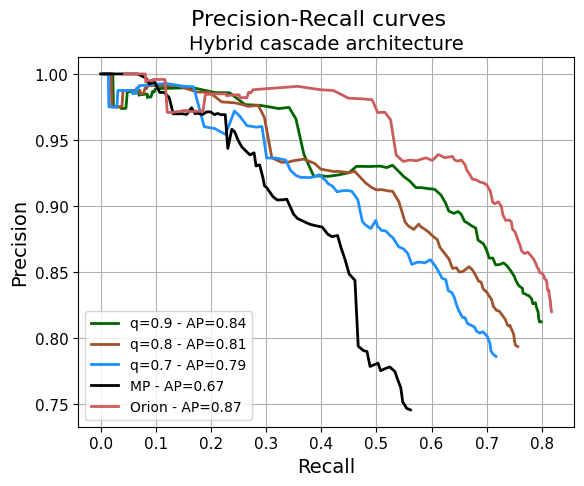

In [ ]:
plt.plot(q09['rec'],q09['prec'], 'darkgreen', lw=2, label='q=0.9 - AP=0.84')
plt.plot(q08['rec'],q08['prec'], 'sienna', lw=2, label='q=0.8 - AP=0.81')
plt.plot(q07['rec'],q07['prec'], 'dodgerblue', lw=2, label='q=0.7 - AP=0.79')
plt.plot(mp['rec'],mp['prec'], 'black', lw=2, label='MP - AP=0.67')
plt.plot(orion['rec'],orion['prec'], 'indianred', lw=2, label='Orion - AP=0.87')

plt.legend()
plt.suptitle("Precision-Recall curves", fontsize=16)

plt.title('Hybrid cascade architecture', fontsize=14)
plt.xlabel('Recall', fontsize=14)
plt.ylabel('Precision', fontsize=14)
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
plt.grid()

# Hyperparameter tuning

## Optimizer

In [ ]:
def objective(trial):

    model = MP(num_categories, num_rotations)
    model.apply(weights_init)

    optimizer_momentum = 0.9

    optimizer_name = trial.suggest_categorical('optimizer',['SGD','Adam'])
    learning_rate = trial.suggest_categorical('learning_rate', [1e-2, 1e-3, 1e-4])
    optimizer_weight_decay = trial.suggest_categorical('optimizer_weight_decay', [1e-3, 1e-4, 1e-5])
    #optimizer_momentum = trial.suggest_float('optimizer_momentum', 0, 0.9)

    if optimizer_name == 'SGD':
        optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=optimizer_momentum, weight_decay=optimizer_weight_decay) #SGD with momentum and L2 regularization
    # elif optimizer_name == 'RMSprop':
    #     optimizer = torch.optim.RMSprop(model.parameters(), lr=learning_rate, weight_decay=optimizer_weight_decay)
    else:
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=optimizer_weight_decay)



    epochs=30
    loss_cat = CrossEntropyLoss()
    loss_rot = CrossEntropyLoss()
    gamma_loss = 0.5

    def loss_total(cat, rot, gamma):
        return (1-gamma)*cat + gamma*rot




    wandb.init(project='Cascade - FC',
        entity='nndl',
        config={
        "model": model,
        "batch size": batch_size,
        "epochs": epochs,
        "learning rate": learning_rate,
        "weight decay": optimizer_weight_decay,
        "momentum": optimizer_momentum,
        "optimizer":  optimizer_name,
        "loss gamma": gamma_loss
        })
    wandb.watch(model, log="all")

    print(f'params {[optimizer_name,learning_rate,optimizer_weight_decay]}')


    model.to(device)
    best_val = np.inf
    for epoch in range(epochs):
        print(f"Epoch: {epoch+1}")
        model.train()
        train_loss, train_loss_cat, train_loss_rot = [], [], []

        iterator = tqdm(train_dataloader)
        for batch_x, batch_y, batch_rot in iterator:
            data_shape = batch_x.shape
            batch_x = batch_x.reshape(batch_size,1,volume,volume,volume).to(device).float()
            batch_y = batch_y.to(device).float()
            batch_rot = batch_rot.to(device).float()

            y_pred = model(batch_x)

            y_pred_cat = y_pred[:,:num_categories]
            lossc = loss_cat(y_pred_cat, batch_y)
            class_ = batch_y.softmax(axis=1).detach().cpu().numpy().argmax(axis=1)

            y_pred_rot = y_pred[:,num_categories:]
            batch_rot_eff = torch.zeros((data_shape[0],num_rotations.sum())).to(device)
            for i in range(data_shape[0]):
                batch_rot_eff[i, sum(num_rotations[:class_[i]]) : sum(num_rotations[:class_[i]]) + num_rotations[class_[i]]] = batch_rot[i,:num_rotations[class_[i]]]
            batch_rot = batch_rot_eff

            lossr = loss_rot(y_pred_rot, batch_rot)
            loss = loss_total(lossc, lossr, gamma_loss)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            #scheduler.step()

            # Save train loss for this batch
            train_loss.append(loss.detach().cpu().numpy())
            train_loss_cat.append(lossc.detach().cpu().numpy())
            train_loss_rot.append(lossr.detach().cpu().numpy())

            del batch_x, batch_y, batch_rot, y_pred, y_pred_cat, lossc, class_, y_pred_rot, lossr, loss

        # Average train loss
        train_loss, train_loss_cat, train_loss_rot = np.mean(train_loss), np.mean(train_loss_cat), np.mean(train_loss_rot)
        print(f"Train loss: {train_loss}")
        #print(f"category: {train_loss_cat}")
        #print(f"alignment: {train_loss_rot}")

        model.eval()
        with torch.no_grad():
            predictions_cat, predictions_rot, labels_cat, labels_rot = [], [], [], []
            for batch_x, batch_y, batch_rot in tqdm(val_dataloader):
                data_shape = batch_x.shape
                batch_x = batch_x.reshape(data_shape[0],1,volume,volume,volume).to(device).float()
                batch_y = batch_y.to(device).float()
                batch_rot = batch_rot.to(device).float()

                y_pred = model(batch_x)

                y_pred_cat = y_pred[:,:num_categories]
                predictions_cat.append(y_pred_cat)
                class_ = batch_y.softmax(axis=1).detach().cpu().numpy().argmax(axis=1)

                y_pred_rot = y_pred[:,num_categories:]
                batch_rot_eff = torch.zeros((data_shape[0],num_rotations.sum())).to(device)
                for i in range(data_shape[0]):
                    batch_rot_eff[i, sum(num_rotations[:class_[i]]) : sum(num_rotations[:class_[i]]) + num_rotations[class_[i]]] = batch_rot[i,:num_rotations[class_[i]]]
                batch_rot = batch_rot_eff

                predictions_rot.append(y_pred_rot)
                labels_cat.append(batch_y)
                labels_rot.append(batch_rot)

                del batch_x, batch_y, batch_rot, y_pred, y_pred_cat, class_, y_pred_rot

            predictions_cat = torch.cat(predictions_cat, axis=0)
            predictions_rot = torch.cat(predictions_rot, axis=0)
            labels_cat = torch.cat(labels_cat, axis=0)
            labels_rot = torch.cat(labels_rot, axis=0)

            # Evaluate validation loss and accuracy
            val_loss_cat = loss_cat(predictions_cat, labels_cat)
            val_loss_rot = loss_rot(predictions_rot, labels_rot)
            val_loss = loss_total(val_loss_cat, val_loss_rot, gamma_loss)

            val_loss = val_loss.detach().cpu().numpy()
            val_acc_cat = accuracy_score(labels_cat.detach().cpu().numpy().argmax(axis=1), predictions_cat.softmax(axis=1).detach().cpu().numpy().argmax(axis=1))
            val_acc_rot = accuracy_score(labels_rot.detach().cpu().numpy().argmax(axis=1), predictions_rot.softmax(axis=1).detach().cpu().numpy().argmax(axis=1))
            print(f"Validation loss: {val_loss}, accuracy: {val_acc_cat}, accuracy rot: {val_acc_rot}")
            #print(f"category loss: {val_loss_cat}")
            #print(f"alignment loss: {val_loss_rot}")


        wandb.log({'epoch': epoch+1, 'train_loss': train_loss, 'train_loss_cat': train_loss_cat, 'train_loss_rot': train_loss_rot,
              'val_loss': val_loss, 'val_loss_cat': val_loss_cat, 'val_loss_rot': val_loss_rot, 'accuracy': val_acc_cat, 'accuracy_rot': val_acc_rot})

        if val_loss < best_val:
            best_val = val_loss


    wandb.finish()

    print(f'Validation loss = {best_val}')
    return best_val

In [ ]:
study = optuna.create_study(direction="minimize", study_name='FC_net_test', load_if_exists=True)
study.optimize(objective, n_trials=10)

In [ ]:
loss, opt, lr, weight_decay= [], [], [], []

for i in study.trials:
  loss.append(i.value)
  opt.append(i.params['optimizer'])
  lr.append(i.params['learning_rate'])
  weight_decay.append(i.params['optimizer_weight_decay'])
  #momentum.append(i.params['optimizer_momentum'])
  #print(f'validation loss = {i.value:.3f} \n with params = {i.params}')

df = pd.DataFrame(
    {'loss': loss,
      'optimizer': opt,
     'learning rate': lr,
     'weight decay': weight_decay
     #'momentum': momentum
     })
df.sort_values("loss")

In [ ]:
opt = ['Adam', 'SGD', 'SGD', 'Adam', 'Adam', 'Adam']
lr = [0.001, 0.001, 0.001, 0.01, 0.0001, 0.001]
weight_decay=[0.0001, 0.001, 0.0001, 0.001, 0.0001, 0.001]
loss = [0.8145456910133362,
 0.7167471051216125,
 0.6818686723709106,
 0.6758236885070801,
 1.2530170679092407,
 0.48034390807151794]
acc = [0.895, 0.848, 0.856, 0.829, 0.837, 0.881]

df_opt = pd.DataFrame(
    {'loss': loss,
     'accuracy': acc,
      'optimizer': opt,
     'learning rate': lr,
     'weight decay': weight_decay
     #'momentum': momentum
     })
df_opt.sort_values("loss")

,loss,accuracy,optimizer,learning rate,weight decay
5,0.480344,0.881,Adam,0.0010,0.0010
3,0.675824,0.829,Adam,0.0100,0.0010
2,0.681869,0.856,SGD,0.0010,0.0001
1,0.716747,0.848,SGD,0.0010,0.0010
0,0.814546,0.895,Adam,0.0010,0.0001
4,1.253017,0.837,Adam,0.0001,0.0001


## Dropout

In [ ]:
class MP(Module):

    def __init__(self, num_categories, num_rotations, dropout=0.4):
        super().__init__()

        # Down Sample to 8x8x8
        self.max_pool = MaxPool3d(kernel_size=4, stride=4)

        # Flatten layer
        self.flatten = Flatten()

        # Fully Connected
        self.fc = Sequential(
            Linear(8*8*8, 256),
            Dropout(dropout),
            LeakyReLU(),

            Linear(256, num_categories + num_rotations.sum()),
            ReLU())


    def forward(self, x):
        x = self.max_pool(x)
        x = self.flatten(x)
        x = self.fc(x)
        return x

In [ ]:
dropout=0.5
model = MP(num_categories, num_rotations, dropout)
model.apply(weights_init)

learning_rate = 0.001
optimizer_weight_decay=0.001

save_parameters, save_folder = False, '/content/drive/My Drive/Dataset/Saved_parameters/'
epochs=30

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=optimizer_weight_decay)

loss_cat = CrossEntropyLoss()
loss_rot = CrossEntropyLoss()
gamma_loss = 0.5

def loss_total(cat, rot, gamma):
    return (1-gamma)*cat + gamma*rot




wandb.init(project='Cascade - FC',
        entity='nndl',
        config={
        "model": model,
        "batch size": batch_size,
        "epochs": epochs,
        "learning rate": learning_rate,
        "weight decay": optimizer_weight_decay,
        "optimizer": 'Adam',
        "dropout": dropout
        })
wandb.watch(model, log="all")




model.to(device)
best_val = np.inf
for epoch in range(epochs):
    print(f"Epoch: {epoch+1}")
    model.train()
    train_loss, train_loss_cat, train_loss_rot = [], [], []

    iterator = tqdm(train_dataloader)
    for batch_x, batch_y, batch_rot in iterator:
        data_shape = batch_x.shape
        batch_x = batch_x.reshape(batch_size,1,volume,volume,volume).to(device).float()
        batch_y = batch_y.to(device).float()
        batch_rot = batch_rot.to(device).float()

        y_pred = model(batch_x)

        y_pred_cat = y_pred[:,:num_categories]
        lossc = loss_cat(y_pred_cat, batch_y)
        class_ = batch_y.softmax(axis=1).detach().cpu().numpy().argmax(axis=1)

        y_pred_rot = y_pred[:,num_categories:]
        batch_rot_eff = torch.zeros((data_shape[0],num_rotations.sum())).to(device)
        for i in range(data_shape[0]):
            batch_rot_eff[i, sum(num_rotations[:class_[i]]) : sum(num_rotations[:class_[i]]) + num_rotations[class_[i]]] = batch_rot[i,:num_rotations[class_[i]]]
        batch_rot = batch_rot_eff

        lossr = loss_rot(y_pred_rot, batch_rot)
        loss = loss_total(lossc, lossr, gamma_loss)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        #scheduler.step()

        # Save train loss for this batch
        train_loss.append(loss.detach().cpu().numpy())
        train_loss_cat.append(lossc.detach().cpu().numpy())
        train_loss_rot.append(lossr.detach().cpu().numpy())

        del batch_x, batch_y, batch_rot, y_pred, y_pred_cat, lossc, class_, y_pred_rot, lossr, loss

    # Average train loss
    train_loss, train_loss_cat, train_loss_rot = np.mean(train_loss), np.mean(train_loss_cat), np.mean(train_loss_rot)
    print(f"Train loss: {train_loss}")
    #print(f"category: {train_loss_cat}")
    #print(f"alignment: {train_loss_rot}")

    model.eval()
    with torch.no_grad():
        predictions_cat, predictions_rot, labels_cat, labels_rot = [], [], [], []
        for batch_x, batch_y, batch_rot in tqdm(val_dataloader):
            data_shape = batch_x.shape
            batch_x = batch_x.reshape(data_shape[0],1,volume,volume,volume).to(device).float()
            batch_y = batch_y.to(device).float()
            batch_rot = batch_rot.to(device).float()

            y_pred = model(batch_x)

            y_pred_cat = y_pred[:,:num_categories]
            predictions_cat.append(y_pred_cat)
            class_ = batch_y.softmax(axis=1).detach().cpu().numpy().argmax(axis=1)

            y_pred_rot = y_pred[:,num_categories:]
            batch_rot_eff = torch.zeros((data_shape[0],num_rotations.sum())).to(device)
            for i in range(data_shape[0]):
                batch_rot_eff[i, sum(num_rotations[:class_[i]]) : sum(num_rotations[:class_[i]]) + num_rotations[class_[i]]] = batch_rot[i,:num_rotations[class_[i]]]
            batch_rot = batch_rot_eff

            predictions_rot.append(y_pred_rot)
            labels_cat.append(batch_y)
            labels_rot.append(batch_rot)

            del batch_x, batch_y, batch_rot, y_pred, y_pred_cat, class_, y_pred_rot

        predictions_cat = torch.cat(predictions_cat, axis=0)
        predictions_rot = torch.cat(predictions_rot, axis=0)
        labels_cat = torch.cat(labels_cat, axis=0)
        labels_rot = torch.cat(labels_rot, axis=0)

        # Evaluate validation loss and accuracy
        val_loss_cat = loss_cat(predictions_cat, labels_cat)
        val_loss_rot = loss_rot(predictions_rot, labels_rot)
        val_loss = loss_total(val_loss_cat, val_loss_rot, gamma_loss)

        val_loss = val_loss.detach().cpu().numpy()
        val_acc_cat = accuracy_score(labels_cat.detach().cpu().numpy().argmax(axis=1), predictions_cat.softmax(axis=1).detach().cpu().numpy().argmax(axis=1))
        val_acc_rot = accuracy_score(labels_rot.detach().cpu().numpy().argmax(axis=1), predictions_rot.softmax(axis=1).detach().cpu().numpy().argmax(axis=1))
        print(f"Validation loss: {val_loss}, accuracy: {val_acc_cat}, accuracy rot: {val_acc_rot}")
        #print(f"category loss: {val_loss_cat}")
        #print(f"alignment loss: {val_loss_rot}")


    wandb.log({'epoch': epoch+1, 'train_loss': train_loss, 'train_loss_cat': train_loss_cat, 'train_loss_rot': train_loss_rot,
          'val_loss': val_loss, 'val_loss_cat': val_loss_cat, 'val_loss_rot': val_loss_rot, 'accuracy': val_acc_cat, 'accuracy_rot': val_acc_rot})

    if val_loss < best_val:
        best_val = val_loss


wandb.finish()

print(f'Validation loss = {best_val}')
#loss_list.append(best_val.item())

In [ ]:
dropout_list = [0.1, 0.2, 0.3, 0.4, 0.5]
loss_list = [0.47395533323287964, 0.48575931787490845, 0.47649651765823364, 0.48409509658813477, 0.4909060001373291]
acc = [0.8895275919732442, 0.8794941471571907, 0.8843018394648829, 0.8903637123745819, 0.88305]

df = pd.DataFrame(
    {'loss': loss_list,
     'accuracy': acc,
     'drop out': dropout_list
     })
df.sort_values("loss")[1:]

,loss,accuracy,drop out
2,0.476497,0.884302,0.3
3,0.484095,0.890364,0.4
1,0.485759,0.879494,0.2
4,0.490906,0.883050,0.5
